# NN Benchmark 
NN benchmark between the transfer learning approach and the neural network trained and tunned on the Stanford dog dataset. 

In [66]:
%load_ext autoreload
%autoreload 2
import os 
import numpy as np 
import tensorflow as tf 
from tensorflow import keras
import mlflow
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt 

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from common.common_params import input_shape, img_dir, model_dir, data_dir, npy_dir
from common.common_img_functions import read_img
from common.common_plots import display_images
from common.common_plots import plot_img
from label_names import label30
from data_load import prepare_subfolder_extract
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from classification_plot import plot_classification_report

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load test data

In [67]:
NB_CLASS = 30 
list_of_folder = np.load(os.path.join(npy_dir,"top_breed_folder_list_30.npy"),  allow_pickle=True)
_, test_dir = prepare_subfolder_extract(100, NB_CLASS, list_of_folder) 
label_name30 = [ name_folder.split("-")[1] for name_folder in label30]

In [95]:
label_name30[12]

'Scottish_deerhound'

In [68]:
test_dir = os.path.join(data_dir,"images_subset","test")

test_ds = keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=1,
    image_size=(input_shape[0],input_shape[1]) )

Found 681 files belonging to 30 classes.


## Load models

In [69]:
def get_model(mlflow_run_id) : 
    data, info = mlflow.get_run(mlflow_run_id)
    NB_CLASS = int(data[1].tags["NB_CLASS"])
    NB_IMG_PER_CLASS =int( data[1].tags["NB_IMG_PER_CLASS"])
    print(f"Number of image used for training in each class :  {NB_IMG_PER_CLASS}")
    # Load model as a Keras model
    save_dir = os.path.join(model_dir, mlflow_run_id)
    model = mlflow.keras.load_model(save_dir)
    return model

## Loss and Accuracy comparison    

In [70]:
print("transfer learning model")
tr_mlflow_run_id = "c072a9d08cc44c91a1b714b7fe396406" # transfer learning model
tr_model = get_model(tr_mlflow_run_id)
tr_test_loss, tr_test_accuracy = tr_model.evaluate(test_ds)
print('Accuracy on test dataset:', tr_test_accuracy)

transfer learning model
Number of image used for training in each class :  100
681/681 [==============================] - 54s 79ms/step - loss: 1.4183 - accuracy: 0.7298
Accuracy on test dataset: 0.7298091053962708


In [71]:
print("personal architecture model")
p_mlflow_run_id = "625e8837200c41afa8fd09b698d6988d" # personal architecture
p_model = get_model(p_mlflow_run_id)
p_test_loss, p_test_accuracy = p_model.evaluate(test_ds)
print('Accuracy on test dataset:', p_test_accuracy)

personal architecture model
Number of image used for training in each class :  200
681/681 [==============================] - 5s 7ms/step - loss: 2.6227 - accuracy: 0.2511
Accuracy on test dataset: 0.2511013150215149


The transfer learning model achieve better result on multi-class classification. It worth mentioning that the CNN model architecture had really good result on binary classification. As this model contains less parameters it could be really interesting for unique dog breed recognition. 

In [72]:
def save_test_metrics(mlflow_run_id, test_loss, test_accuracy): 
    # save test metrics
    with mlflow.start_run(run_id=mlflow_run_id):
        mlflow.log_metric("test_loss", test_loss)
        mlflow.log_metric("test_accuracy",test_accuracy)

save_test_metrics(tr_mlflow_run_id, tr_test_loss, tr_test_accuracy)
save_test_metrics(p_mlflow_run_id, p_test_loss, p_test_accuracy)


In [73]:
test_img = read_img(os.path.join(data_dir , "extracted\\test\\n02085936-Maltese_dog\\n02085936_233_0.jpg"))
test_imge = np.expand_dims(test_img, axis=0)
class_names_from_folder = [ name.split('-')[1] for name in label30 ]
predictions = tr_model.predict(test_imge)[0]
print(f"This image as a probability {round(100*predictions[0],2)}% \
    {class_names_from_folder[0]} of and a probability { round(100*predictions[1],2)}% of {class_names_from_folder[1]}")

This image as a probability 100.0%     Maltese_dog of and a probability 0.0% of Shih


True label : chow
Predicted  : chow


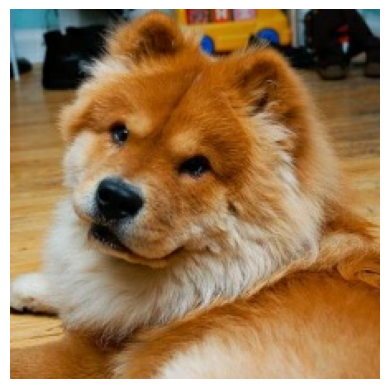

In [74]:
for img, label in test_ds.take(1):
    label_idx = np.argmax(label)
    print(f"True label : {label_name30[label_idx]}")
    
    prediction = tr_model.predict(img)
    y_pred = np.argmax(prediction)
    print(f"Predicted  : {label_name30[y_pred]}")

    plot_img( img[0].numpy().astype("uint8"))
    

In [75]:
# Initialize empty lists to accumulate true labels and predictions
true_labels = []
predicted_labels = []
img_set = []
label_set = []
# Iterate over the test dataset
for img, label in test_ds.take(600):
    true_labels.extend(np.argmax(label.numpy(), axis=1))  # Convert one-hot label to class index
    prediction = np.argmax(tr_model.predict(img, verbose=0), axis=1)
    predicted_labels.extend(prediction)

    img_set.append(img)
    label_set.append(label)
# Convert accumulated lists to numpy arrays
y_true = np.array(true_labels)
y_pred = np.array(predicted_labels)


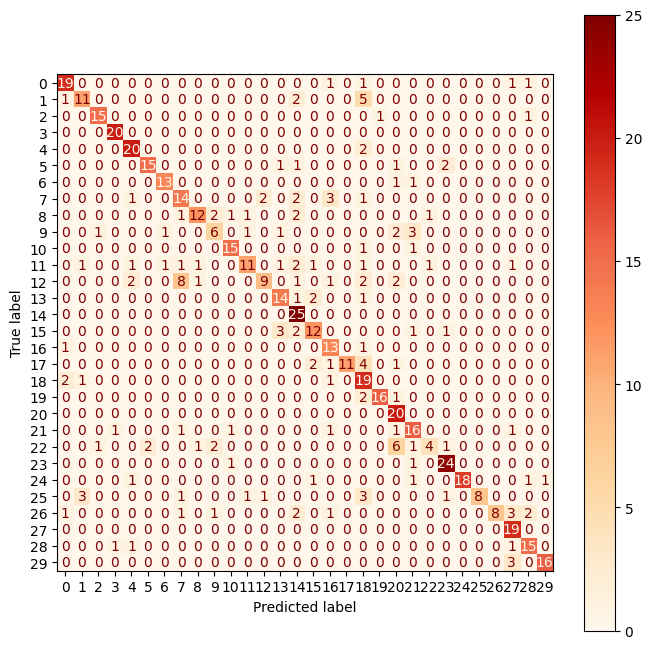

In [76]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels = np.arange(NB_CLASS))
cmp = ConfusionMatrixDisplay(conf_matrix)


fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax,cmap= "OrRd")
plt.show()


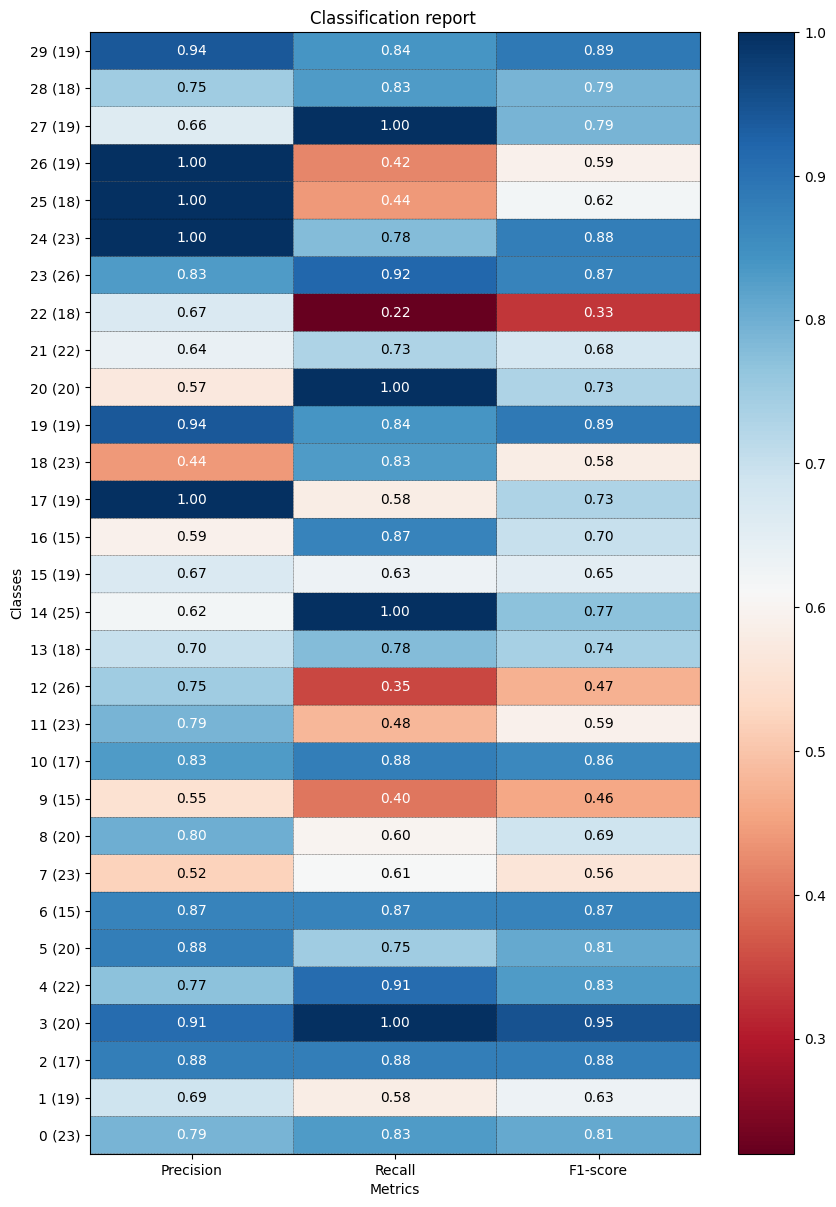

In [77]:
cr = classification_report(y_true, y_pred)
plot_classification_report(cr)

In [78]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        23
           1       0.69      0.58      0.63        19
           2       0.88      0.88      0.88        17
           3       0.91      1.00      0.95        20
           4       0.77      0.91      0.83        22
           5       0.88      0.75      0.81        20
           6       0.87      0.87      0.87        15
           7       0.52      0.61      0.56        23
           8       0.80      0.60      0.69        20
           9       0.55      0.40      0.46        15
          10       0.83      0.88      0.86        17
          11       0.79      0.48      0.59        23
          12       0.75      0.35      0.47        26
          13       0.70      0.78      0.74        18
          14       0.62      1.00      0.77        25
          15       0.67      0.63      0.65        19
          16       0.59      0.87      0.70        15
          17       1.00    

In [79]:
# Initialize empty lists to accumulate true labels and predictions
true_labels = []
predicted_labels = []
img_set = []
label_set = []
# Iterate over the test dataset
for img, label in test_ds.take(600):
    true_labels.extend(np.argmax(label.numpy(), axis=1))  # Convert one-hot label to class index
    prediction = np.argmax(p_model.predict(img, verbose=0), axis=1)
    predicted_labels.extend(prediction)

    img_set.append(img)
    label_set.append(label)
# Convert accumulated lists to numpy arrays
y_true = np.array(true_labels)
y_pred = np.array(predicted_labels)


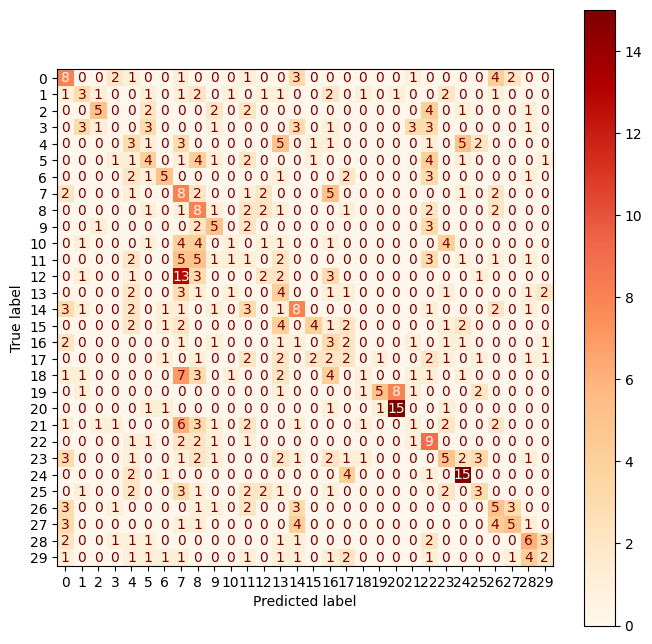

In [80]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels = np.arange(NB_CLASS))
cmp = ConfusionMatrixDisplay(conf_matrix)


fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax,cmap= "OrRd")
plt.show()


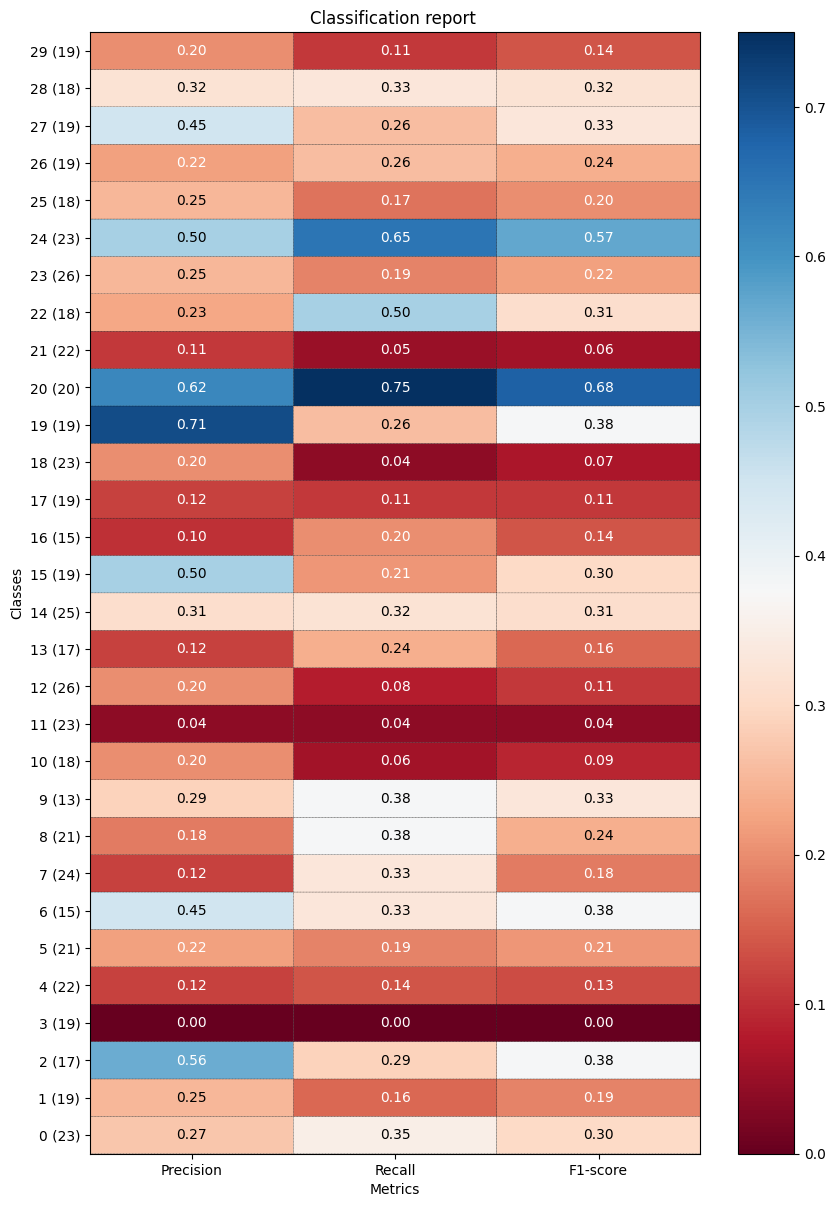

In [82]:
cr = classification_report(y_true, y_pred)
plot_classification_report(cr)

## Error classification study 

In [83]:
def get_wrong_label_imgs(model, label_idx) : 

    nb = len(label_set)

    fp_predictions  = []
    to_be_displayed = []
    for i in range(nb) : 
        breedidx = np.argmax(label_set[i].numpy(), axis=1)[0]
        if breedidx == label_idx : 

            predicted = np.argmax(model.predict(img_set[i], verbose=0), axis=1)[0]
            if predicted != label_idx : 
                to_be_displayed.append(img_set[i][0].numpy().astype("uint8")) 
                fp_predictions.append(predicted)

    return to_be_displayed, fp_predictions



In [84]:
def display_9_fp(model, id) : 
    to_be_displayed, fp_predictions = get_wrong_label_imgs(model, id)
    display_images(to_be_displayed, 2, 2, from_path=False, main_title=f"{label_name30[id]} wrongly classified", titles = [label_name30[k] for k in fp_predictions])

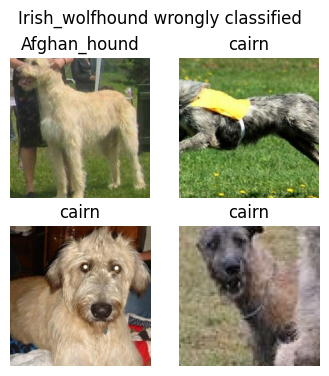

In [85]:
display_9_fp(p_model, 7)

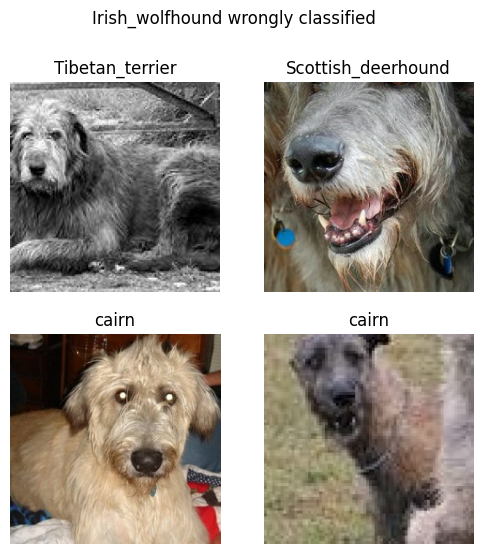

In [92]:
display_9_fp(tr_model, 7)

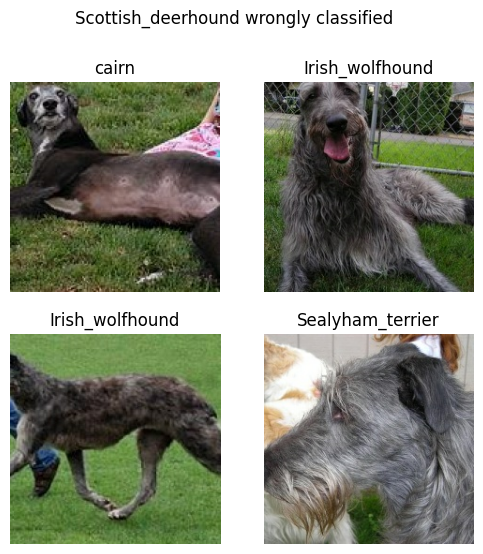

In [93]:
display_9_fp(tr_model, 12)

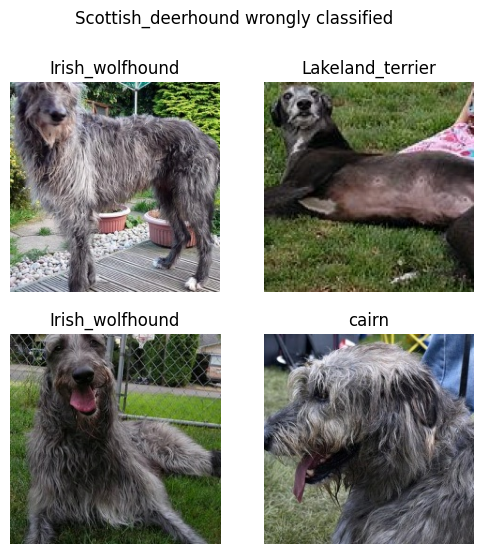

In [96]:
display_9_fp(p_model, 12)

Label  7 (irish wolfhound ) and 12 (scottish deerhoud)   are  wrongly classified by both NN. Actually this task is also complicated for humans. This [blog](https://www.akc.org/expert-advice/lifestyle/difference-between-irish-wolfhound-scottish-deerhound/) explains how to tell both apart. 

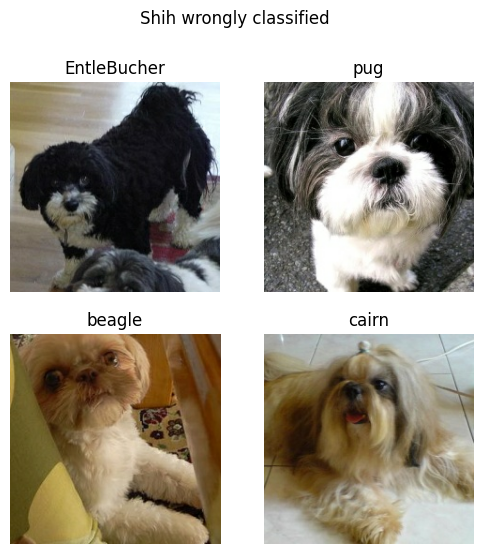

In [99]:
display_9_fp(p_model, 1)

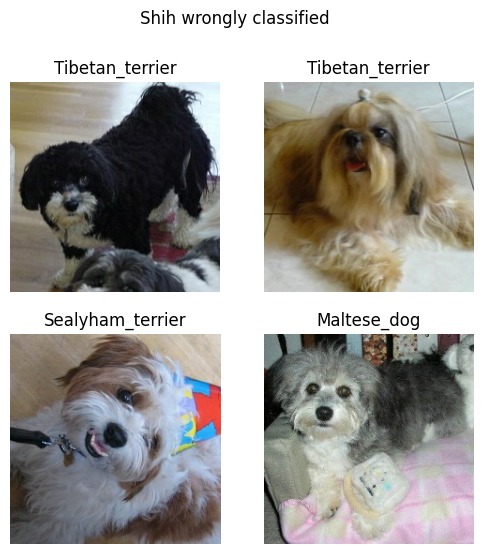

In [97]:
display_9_fp(tr_model, 1)

Very sensitive to color beagle(white, brown and black), airedale same issue. 

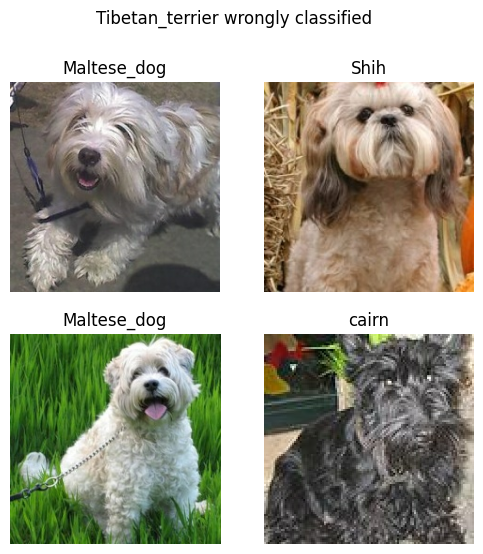

In [98]:
id = 18 
to_be_displayed, fp_predictions = get_wrong_label_imgs(tr_model, id)
display_images(to_be_displayed,2,2,from_path=False, main_title=f"{label_name30[id]} wrongly classified", titles = [label_name30[k] for k in fp_predictions])

Tibetan terrier and Shih are also complicated to classify. The idea to improve classification would be to have dedicated network for breed that gets confused a lot if this error is crucial for production. 